# Imports

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, LeakyReLU, Flatten
import time

from tensorflow.keras.layers import Lambda
#from keras.backend import slice

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Ploting
import matplotlib.pyplot as plt
%matplotlib inline

# Data Load and Process

In [3]:
#for use in google colaboratory
#!git clone https://github.com/shusunny/GAN-stock-entry.git

In [4]:
data_names = ["GOOG","AAPL","AMZN","FB","TSLA"]
data_name = data_names[0]
data_path="GAN-stock-entry/datasets/"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path)

datasets/GOOG.csv


In [5]:
dataframe.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,1089.420897,1100.046811,1079.321435,1090.083688,1090.083688,1.671534e+06
std,268.589405,272.693779,265.381490,269.099996,269.099996,7.686312e+05
min,667.849976,672.299988,663.059998,668.260010,668.260010,3.468000e+05
25%,835.755005,841.975006,831.254975,836.994995,836.994995,1.209400e+06
50%,1083.560059,1094.244995,1072.204956,1082.760010,1082.760010,1.466700e+06
75%,1229.390015,1241.369995,1219.445007,1230.540039,1230.540039,1.889050e+06
max,1824.520020,1847.199951,1822.650024,1827.989990,1827.989990,6.348100e+06


In [6]:
dataframe.shape

(1259, 7)

In [7]:
def add_Entry(dataframe):
  for i in range(0,dataframe.shape[0]):
    dataframe.loc[dataframe.index[i],'Entry'] = np.round((dataframe.iloc[i,3]+ (dataframe.iloc[i,2] -dataframe.iloc[i,3])*0.2),5)
  return dataframe

dataframe=add_Entry(dataframe)
dataframe.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Entry
0,2016-01-04,743.000000,744.059998,731.257996,741.840027,741.840027,3272800,733.81840
1,2016-01-05,746.450012,752.000000,738.640015,742.580017,742.580017,1950700,741.31201
2,2016-01-06,730.000000,747.179993,728.919983,743.619995,743.619995,1947000,732.57198
3,2016-01-07,730.309998,738.500000,719.059998,726.390015,726.390015,2963700,722.94800
4,2016-01-08,731.450012,733.229980,713.000000,714.469971,714.469971,2450900,717.04600


In [8]:
np.where(dataframe.to_numpy()==0)

(array([], dtype=int64), array([], dtype=int64))

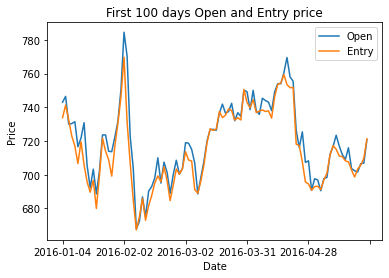

In [8]:
ax = plt.gca()
dataframe.iloc[0:100].plot(x='Date',y='Open',ax=ax)
dataframe.iloc[0:100].plot(x='Date',y='Entry', ax=ax)

plt.title("First 100 days Open and Entry price")
plt.ylabel("Price")
plt.show()

# Data Preparing

In [10]:
class Standarized_TimeseriesGenerator(tf.keras.preprocessing.sequence.TimeseriesGenerator):
  def __getitem__(self, index):
    samples, targets  = super(Standarized_TimeseriesGenerator, self).__getitem__(index)
    # shape : (n_batch, n_sequence, n_features)
    mean = samples.mean(axis=1)
    std = samples.std(axis=1)
    samples = (samples - mean[:,None,:])/std[:,None,:] #standarize along each feature
    targets = (targets - mean)/std # The Entry value is our target
    return samples, targets

In [11]:
# TimeseriesGenerator Check

data = np.array([[i, i**2,i**3,i**4] for i in range(11)])
#targets = np.array([[i**4] for i in range(11)])
targets = data

mean = data[:-1].mean(axis=0)[None,:]
std = data[:-1].std(axis=0)[None,:]

data_gen = Standarized_TimeseriesGenerator(data, targets,
                               length=10, sampling_rate=1,
                               batch_size=2)
batch_0 = data_gen[0]
x, y = batch_0

print(np.array(x*std+mean,dtype = np.int))
print(y*std+mean)

[[[   0    0    0    0]
  [   1    1    1    1]
  [   2    4    8   16]
  [   3    9   27   81]
  [   4   16   64  256]
  [   5   25  125  625]
  [   6   36  216 1296]
  [   7   49  343 2401]
  [   8   64  512 4096]
  [   9   81  729 6561]]]
[[   10.   100.  1000. 10000.]]


In [12]:
n_sequence = 5
n_features = 7
n_batch = 32

def get_gen_train_test(dataframe):
  data = dataframe.drop(columns='Date').to_numpy()

  targets = data
  n_samples = data.shape[0]
  train_test_split=int(n_samples*0.9)

  data_gen_train = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = 0,
                                end_index = train_test_split,
                                shuffle = True)
  data_gen_test = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = train_test_split,
                                end_index = n_samples-1)

  return data_gen_train, data_gen_test

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

In [13]:
data_gen_train[0]

(array([[[-1.15349983, -0.53387181, -0.61612911, ...,  0.06048451,
           1.43085172, -0.61860737],
         [ 0.10227845,  1.13593844,  0.25602237, ...,  0.71754947,
          -0.38666269,  0.47233363],
         [ 1.56872357,  0.68239407,  0.46164188, ..., -0.80944661,
          -0.54054121,  0.53000377],
         [-0.98819587, -1.67519778, -1.52327725, ..., -1.36736404,
           0.83999567, -1.61307884],
         [ 0.47069368,  0.39073707,  1.42174212, ...,  1.39877666,
          -1.34364349,  1.22934882]],
 
        [[ 0.46714424,  1.15764358,  0.93663805, ...,  0.7815501 ,
           0.18263201,  0.97878227],
         [ 1.24752051,  1.24015481,  0.73913001, ...,  0.85227422,
          -1.47675102,  0.80377197],
         [-1.79481661, -1.07040546, -0.31074322, ..., -0.08621465,
           0.34956908, -0.39067294],
         [ 0.01898053, -0.44560987,  0.44624536, ...,  0.33475894,
          -0.58071272,  0.3705123 ],
         [ 0.06117133, -0.88178306, -1.8112702 , ..., -1.8823

In [14]:
data.shape

(11, 4)

In [15]:
# test on data
data = dataframe.drop(columns='Date').to_numpy()
targets = data

x_gen, y_gen = Standarized_TimeseriesGenerator(data, targets,
                               length=5, sampling_rate=1,
                               stride=1, batch_size=1)[0]
print(x_gen)
print(y_gen)

x = data[None, :5,:]
mean = x.mean(axis=1)
std = x.std(axis=1)
x = (x - mean)/std
y = (data[5] - mean)/std
print('x:', x)
print('y:', y)

assert (x_gen == x).all()
assert (y_gen == y).all()

[[[ 0.9615339   0.16245112  0.55924707  0.69799102  0.69799102
    1.4178268   0.50040009]
  [ 1.45240481  1.37244886  1.37153545  0.76207352  0.76207352
   -1.06240397  1.37670208]
  [-0.88811819  0.63791534  0.3019813   0.85213473  0.85213473
   -1.06934509  0.35464386]
  [-0.84401139 -0.68485157 -0.78297272 -0.63996682 -0.63996682
    0.83796194 -0.77078337]
  [-0.68180913 -1.48796375 -1.4497911  -1.67223245 -1.67223245
   -0.12403968 -1.46096265]]]
[[-2.79326197 -3.67860772 -2.49073477 -1.53713276 -1.53713276 -0.79995462
  -2.68216834]]
x: [[[ 0.9615339   0.16245112  0.55924707  0.69799102  0.69799102
    1.4178268   0.50040009]
  [ 1.45240481  1.37244886  1.37153545  0.76207352  0.76207352
   -1.06240397  1.37670208]
  [-0.88811819  0.63791534  0.3019813   0.85213473  0.85213473
   -1.06934509  0.35464386]
  [-0.84401139 -0.68485157 -0.78297272 -0.63996682 -0.63996682
    0.83796194 -0.77078337]
  [-0.68180913 -1.48796375 -1.4497911  -1.67223245 -1.67223245
   -0.12403968 -1.46096

# Baseline 

In [16]:
# baseline: use previous days as estimation for the next
squared_error = 0
def mean_squared_error(X, lenght = 5):
  squared_error = 0
  for i in range(0, X.shape[0] - lenght):
    x = X[i:i+lenght]
    mean = x.mean()
    std = x.std()
    x = (x - mean)/std
    y = (X[i+lenght] - mean)/std
    squared_error += np.square(x[-1]-y)
  return squared_error/X.shape[0]

baseline_error = mean_squared_error(data[:,6])
baseline_error

4.317263898988826

In [17]:
data_gen = Standarized_TimeseriesGenerator(data, targets,
                               length=5, sampling_rate=1,
                               stride=1, batch_size=32)

# baseline: use previous day as estimation for the next
def mean_squared_error(dataset):
  mse=0
  for X_batch, y_batch in dataset:
    # X_batch.shape : (n_batch, n_sequence, n_features)
    mse += np.mean(np.square(X_batch[:, -1, 6:7]-y_batch[:, 6:7]))
  mse /= len(dataset)
  return mse

baseline_error = mean_squared_error(data_gen)
baseline_error 

4.280646182369636

# Utilities

In [18]:
# Metrics not included in keras

# For some reason keras mape is different so it has to be customly defined.
# Paper definition isn't percentual, hence the difference. (x100)
def mse(y_true, y_pred):
  return tf.reduce_mean(tf.square(y_true[:,6]-y_pred[:,6]))
def mae(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,6]-y_pred[:,6])))
    # ***The absolute is over the whole thing as y_true can be negative
def mape(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,6]-y_pred[:,6])/y_true[:,6]))
    # ***The absolute is over the whole thing as y_true can be negative
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true[:,6]-y_pred[:,6])))
def ar(y_true, y_pred):
    mask = tf.cast(y_pred[1:,6] > y_true[:-1,6],tf.float32)
    return tf.reduce_mean((y_true[1:,6]-y_true[:-1,6])*mask)

 

# GAN

## Loss Define

In [19]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(x, y, fake_output):
    a1=0.01
    g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
    g_mse = tf.keras.losses.MSE(x, y)
    return a1*g_mse + (1-a1)*g_loss, g_mse


## Generator

In [20]:
def make_generator_model():

  inputs = Input(shape=(n_sequence, n_features,))
  lstm_1 = LSTM(units=10, return_sequences = True, activation=None, kernel_initializer='random_normal')(inputs)
  batch_norm1=tf.keras.layers.BatchNormalization()(lstm_1)
  lstm_1_LRelu = LeakyReLU(alpha=0.3)(batch_norm1) 
  lstm_1_droput = Dropout(0.3)(lstm_1_LRelu)
  lstm_2 = LSTM(units=10, return_sequences = False, activation=None, kernel_initializer='random_normal')(lstm_1_droput)
  batch_norm2=tf.keras.layers.BatchNormalization()(lstm_2)
  lstm_2_LRelu = LeakyReLU(alpha=0.3)(batch_norm2) 
  lstm_2_droput = Dropout(0.3)(lstm_2_LRelu)
  #lstm_3 = LSTM(units=10, return_sequences = False, activation=None, kernel_initializer='random_normal')(lstm_2_droput)
  #batch_norm3=tf.keras.layers.BatchNormalization()(lstm_3)
  #lstm_3_LRelu = LeakyReLU(alpha=0.3)(batch_norm3) 
  #lstm_3_droput = Dropout(0.3)(lstm_3_LRelu)
  #lstm_4 = LSTM(units=100, return_sequences = False, activation=None, kernel_initializer='random_normal')(lstm_3_droput)
  #batch_norm4=tf.keras.layers.BatchNormalization()(lstm_4)
  #lstm_4_LRelu = LeakyReLU(alpha=0.3)(batch_norm4) 
  #lstm_4_droput = Dropout(0.5)(lstm_4_LRelu)
  output_dense = Dense(n_features, activation=None)(lstm_2_droput)
  output = LeakyReLU(alpha=0.3)(output_dense) 

  model = Model(inputs = inputs, outputs = output)
  model.compile(loss=None, metrics = [mse , mae, mape, rmse, ar])
  model.summary()

  #return model, slice_model
  return model
 

In [21]:
generator = make_generator_model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 5, 10)             720       
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 10)             40        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 5, 10)             0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 10)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                840       
_________________________________________________________________
batch_normalization_1 (Batch (None, 10)                40    

## Discriminator

In [22]:
def make_discriminator_model():
  model = Sequential()
  model.add(Flatten())
  model.add(Dense(units=72, input_shape=((n_sequence+1) * n_features,), activation=None, kernel_initializer='random_normal'))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
  model.add(tf.keras.layers.GaussianNoise(stddev=0.2))
  model.add(Dropout(0.3))
  model.add(Dense(units=100, activation=None, kernel_initializer='random_normal'))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
  model.add(Dropout(0.3))
  model.add(Dense(units=10, activation=None, kernel_initializer='random_normal'))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
  model.add(Dropout(0.3))
  model.add(Dense(1 ,activation='sigmoid'))
  model.compile(loss=discriminator_loss)

  return model


In [23]:
discriminator=make_discriminator_model()

In [24]:
learning_rate=1e-4
generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

## Training

In [25]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [26]:
EPOCHS = 500

In [27]:
def train_step_def(sequences, sequences_end):
  # sequences is the real output

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_prediction = generator(sequences, training=True)

    sequences_true = tf.concat((sequences, sequences_end[:, None, :]), axis=1)
    sequences_fake = tf.concat((sequences, generated_prediction[:, None, :]), axis=1)

    real_output = discriminator(sequences_true, training=True)
    fake_output = discriminator(sequences_fake, training=True)

    gen_loss, gen_mse_loss = generator_loss(generated_prediction, 
                                            sequences_end, 
                                            fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

def test_step_def(sequences, sequences_end):
  generated_prediction = generator(sequences, training=False)

  sequences_true = tf.concat((sequences, sequences_end[:,None,:]), axis=1)
  sequences_fake = tf.concat((sequences, generated_prediction[:,None,:]), axis=1)

  real_output = discriminator(sequences_true, training=False)
  fake_output = discriminator(sequences_fake, training=False)

  gen_loss, gen_mse_loss = generator_loss(generated_prediction, sequences_end, fake_output)
  disc_loss = discriminator_loss(real_output, fake_output)
  return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

In [29]:
def train(dataset, dataset_val, epochs):
  history = np.empty(shape = (8, epochs))
  history_val = np.empty(shape = (8, epochs))
  len_dataset = len(dataset)
  len_dataset_val = len(dataset_val)
  for epoch in range(epochs):
    start = time.time()

    cur_dis_loss = 0
    cur_gen_loss = 0
    cur_gen_mse_loss = 0
    for sequence_batch, sequence_end_batch in dataset:
      aux_cur_losses = train_step(tf.cast(sequence_batch, tf.float32), 
                                  tf.cast(sequence_end_batch, tf.float32))
      cur_gen_loss += aux_cur_losses[0]/len_dataset
      cur_dis_loss += aux_cur_losses[1]/len_dataset
      cur_gen_mse_loss += aux_cur_losses[2]/len_dataset

    #cur_gen_loss = generator.evaluate(dataset,verbose=False)
    cur_gen_metrics = generator.evaluate(dataset,verbose=False)[1:]
    #cur_dis_loss = discriminator.evaluate(dataset,verbose=False)

    history[:, epoch] = cur_gen_loss, cur_dis_loss, cur_gen_mse_loss, *cur_gen_metrics
    #history[:, epoch] = cur_gen_loss, *cur_gen_slice_metrics

    #cur_gen_loss_val = generator.evaluate(dataset_val,verbose=False)
    cur_gen_metrics_val = generator.evaluate(dataset_val,verbose=False)[1: ]

    #cur_dis_loss_val = discriminator.evaluate(dataset_val,verbose=False)

    cur_gen_loss_val = 0
    cur_dis_loss_val = 0
    cur_gen_mse_loss_val = 0
    for sequence_batch, sequence_end_batch in dataset_val:
      aux_cur_losses_val = test_step(tf.cast(sequence_batch, tf.float32), 
                                     tf.cast(sequence_end_batch, tf.float32))
      cur_gen_loss_val += aux_cur_losses_val[0]/len_dataset_val
      cur_dis_loss_val += aux_cur_losses_val[1]/len_dataset_val
      cur_gen_mse_loss_val += aux_cur_losses_val[2]/len_dataset_val
    


    history_val[:, epoch] = cur_gen_loss_val, cur_dis_loss_val, cur_gen_mse_loss_val, *cur_gen_metrics_val

    print ('Time for epoch {} is {} sec Generator Loss: {},  Discriminator_loss: {}'
           .format(epoch + 1, time.time()-start, cur_gen_loss, cur_dis_loss))
      
    # Save the model every 10 epochs
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

  return history, history_val

## Visualization

In [31]:
metrics = ["Gen_loss","Dis_loss","Gen_mse_loss", 'MSE','MAE','MAPE','RMSE','AR']

def plot_history(history, history_val):
  for i, metric_name in enumerate(metrics):  
    plt.figure()
    plt.title(metric_name)
    plt.xlabel('Iterations')
    plt.ylabel(metric_name)
    plt.plot(history[i], label='train')
    plt.plot(history_val[i], label='test')
    plt.legend()
  plt.show()

#plot_history(history, history_val)

In [32]:
def plot_frame(sequence, target, model):
  sequence, target = data_gen_test[0]
  y_pred = model.predict(sequence)[...,6]
  y_true = target[...,6]

  plt.figure()
  plt.title("Entry price errors")
  plt.xlabel('Test samples')
  plt.ylabel("Errors")
  plt.plot(y_true, label="true")
  plt.plot(y_pred, label="prediction")
  plt.legend()
  plt.show()

#plot_frame(*data_gen_test[0], generator)

In [33]:
def get_best_results(history):
  # get best mse
  min_index = np.argmin(history[6, :])

  return history[:, min_index]

#get_best_results(history_val)

# Test on all datasets

In [34]:
results = np.zeros((5,8))

### Google Stock

GAN-stock-entry/datasets/GOOG.csv
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 10)             720       
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 10)             40        
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 5, 10)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 10)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10)                840       
_________________________________________________________________
batch_normalization_3 (Ba

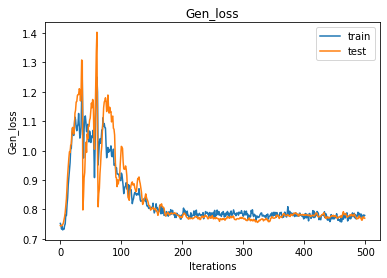

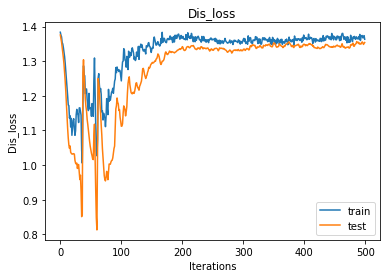

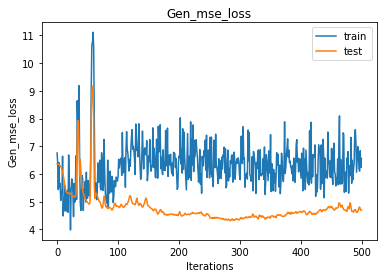

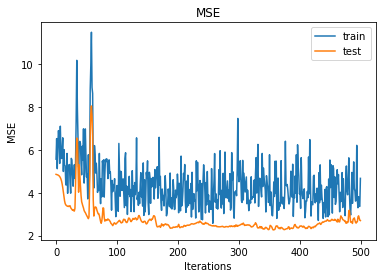

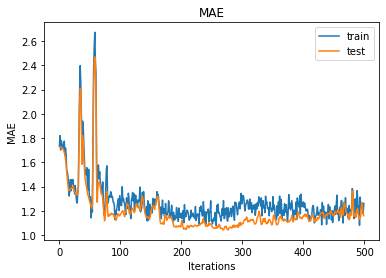

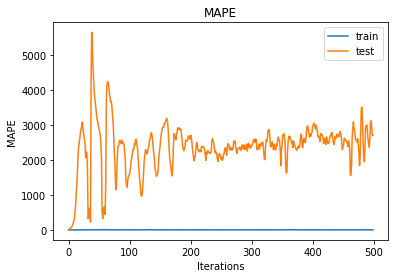

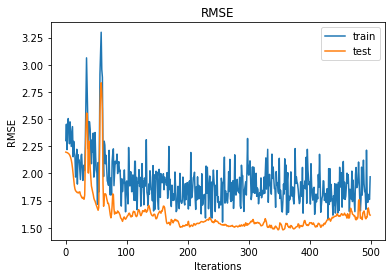

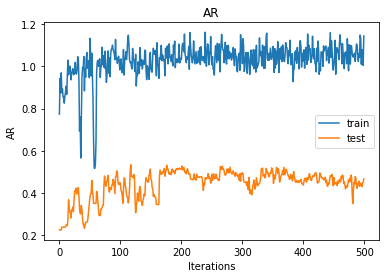

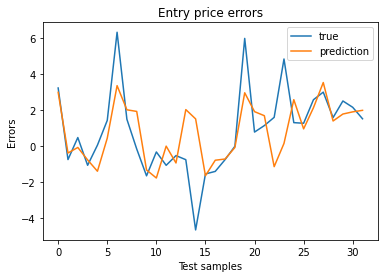

[MSE Baseline] train: 3.4734146598267803  test: 2.812859025419686
['Gen_loss', 'Dis_loss', 'Gen_mse_loss', 'MSE', 'MAE', 'MAPE', 'RMSE', 'AR'] =
 [7.79215932e-01 1.34168816e+00 4.46181393e+00 2.26379442e+00
 1.08449018e+00 1.86437854e+03 1.48015833e+00 5.21022797e-01]


In [35]:
i = 0 #data_names = ["GOOG","AAPL","AMZN","FB","TSLA"]

data_name = data_names[i]
data_path="GAN-stock-entry/datasets/"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path).dropna()

dataframe = add_Entry(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

generator = make_generator_model()
discriminator=make_discriminator_model()

learning_rate=1e-4
generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

@tf.function
def train_step(sequences, sequences_end):
  return train_step_def(sequences, sequences_end)

@tf.function
def test_step(sequences, sequences_end):
  return test_step_def(sequences, sequences_end)

checkpoint_dir = './training_checkpoints'+data_name
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

history, history_val = train(data_gen_train, data_gen_test, EPOCHS)

plot_history(history, history_val)
plot_frame(*data_gen_test[0], generator)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))

results[i] = get_best_results(history_val)
print(metrics,"=\n",results[i])

### Apple Stock

GAN-stock-entry/datasets/AAPL.csv
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 10)             720       
_________________________________________________________________
batch_normalization_4 (Batch (None, 5, 10)             40        
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 5, 10)             0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 5, 10)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 10)                840       
_________________________________________________________________
batch_normalization_5 (Ba

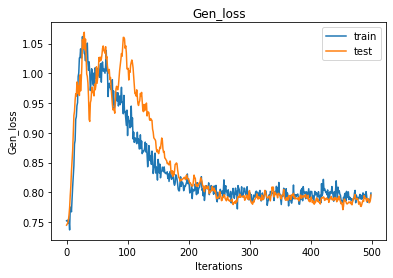

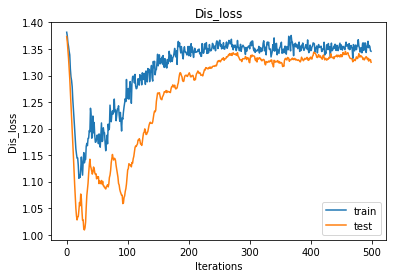

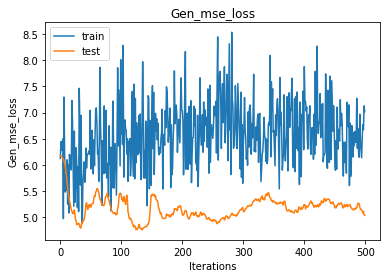

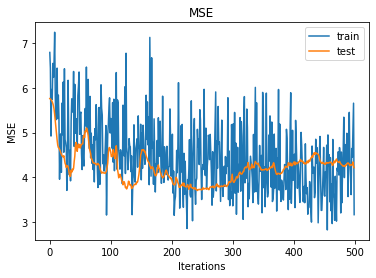

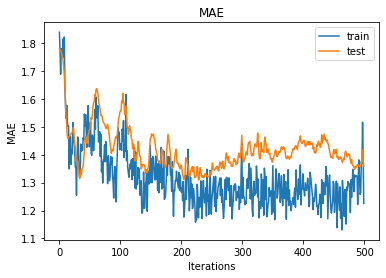

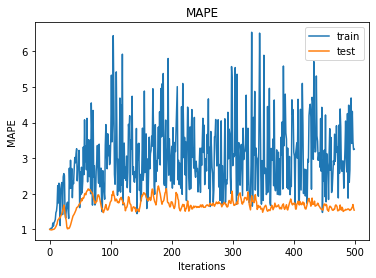

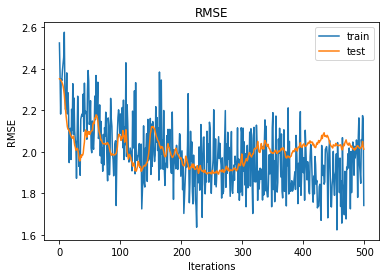

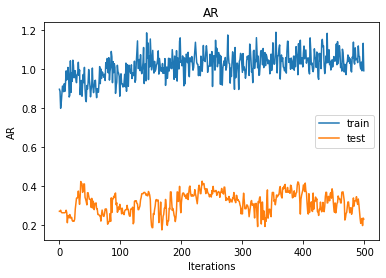

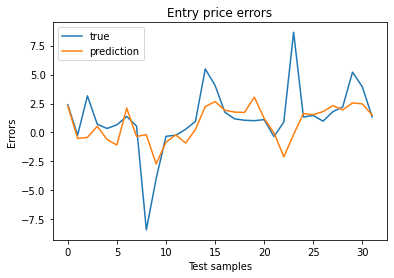

[MSE Baseline] train: 4.031556165453297  test: 3.883730321570804
['Gen_loss', 'Dis_loss', 'Gen_mse_loss', 'MSE', 'MAE', 'MAPE', 'RMSE', 'AR'] =
 [0.78849268 1.33198905 4.91281796 3.72241735 1.34160376 1.64970636
 1.89310646 0.37183356]


In [36]:
i = 1 #data_names = ["GOOG","AAPL","AMZN","FB","TSLA"]

data_name = data_names[i]
data_path="GAN-stock-entry/datasets/"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path).dropna()

dataframe = add_Entry(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

generator = make_generator_model()
discriminator=make_discriminator_model()

learning_rate=1e-4
generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

@tf.function
def train_step(sequences, sequences_end):
  return train_step_def(sequences, sequences_end)

@tf.function
def test_step(sequences, sequences_end):
  return test_step_def(sequences, sequences_end)

checkpoint_dir = './training_checkpoints'+data_name
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

history, history_val = train(data_gen_train, data_gen_test, EPOCHS)

plot_history(history, history_val)
plot_frame(*data_gen_test[0], generator)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))

results[i] = get_best_results(history_val)
print(metrics,"=\n",results[i])

### Amazon Stock

GAN-stock-entry/datasets/AMZN.csv
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 5, 10)             720       
_________________________________________________________________
batch_normalization_6 (Batch (None, 5, 10)             40        
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 5, 10)             0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 5, 10)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 10)                840       
_________________________________________________________________
batch_normalization_7 (Ba

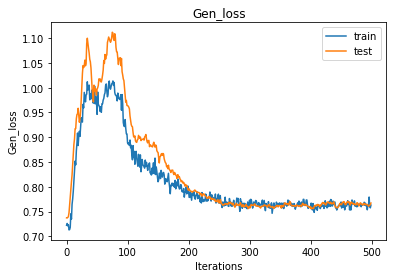

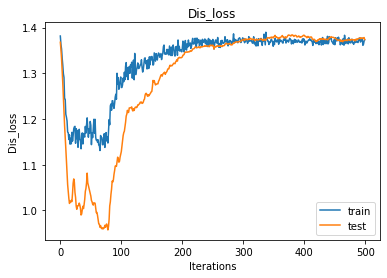

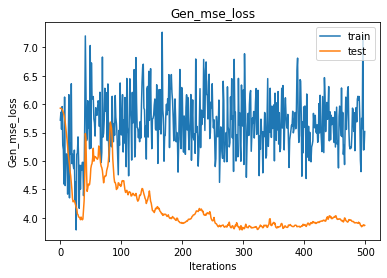

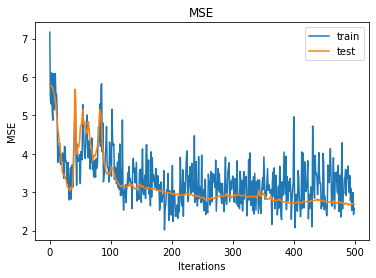

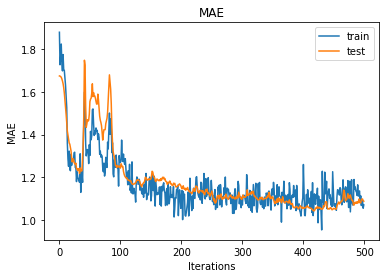

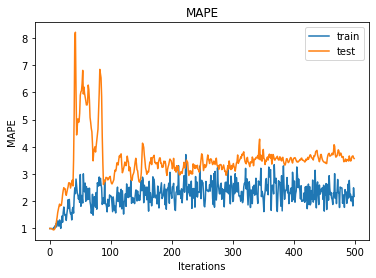

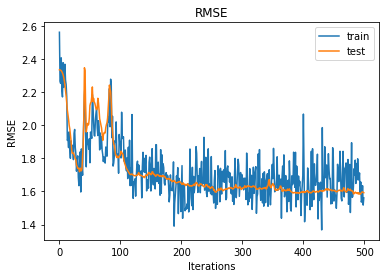

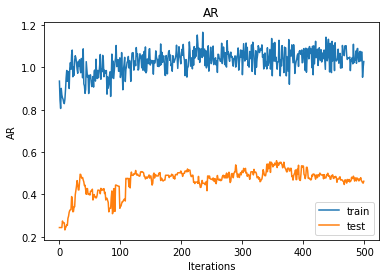

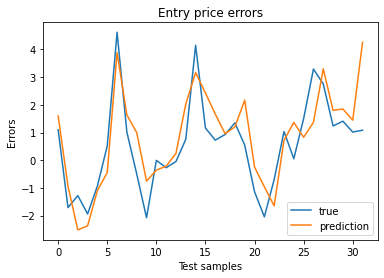

[MSE Baseline] train: 3.8738038970814532  test: 3.8536905955453555
['Gen_loss', 'Dis_loss', 'Gen_mse_loss', 'MSE', 'MAE', 'MAPE', 'RMSE', 'AR'] =
 [0.76436394 1.37584233 3.85927653 2.66944551 1.08177352 3.48044658
 1.58373106 0.4725101 ]


In [37]:
i = 2 #data_names = ["GOOG","AAPL","AMZN","FB","TSLA"]
data_name = data_names[i]
data_path="GAN-stock-entry/datasets/"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path).dropna()

dataframe = add_Entry(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

generator = make_generator_model()
discriminator=make_discriminator_model()

learning_rate=1e-4
generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

@tf.function
def train_step(sequences, sequences_end):
  return train_step_def(sequences, sequences_end)

@tf.function
def test_step(sequences, sequences_end):
  return test_step_def(sequences, sequences_end)

checkpoint_dir = './training_checkpoints'+data_name
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

history, history_val = train(data_gen_train, data_gen_test, EPOCHS)

plot_history(history, history_val)
plot_frame(*data_gen_test[0], generator)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))

results[i] = get_best_results(history_val)
print(metrics,"=\n",results[i])

### Facebook Stock

GAN-stock-entry/datasets/FB.csv
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 5, 10)             720       
_________________________________________________________________
batch_normalization_8 (Batch (None, 5, 10)             40        
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 5, 10)             0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 5, 10)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 10)                840       
_________________________________________________________________
batch_normalization_9 (Batc

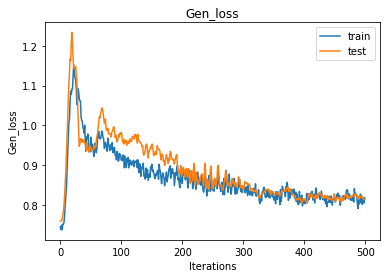

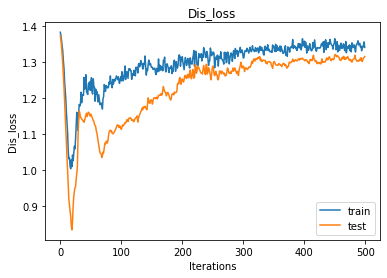

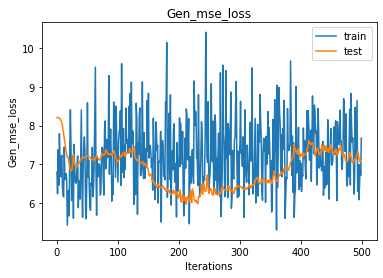

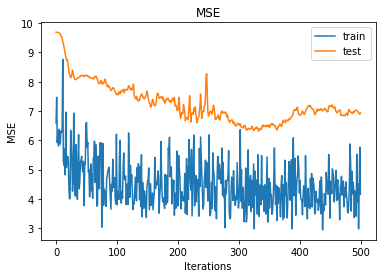

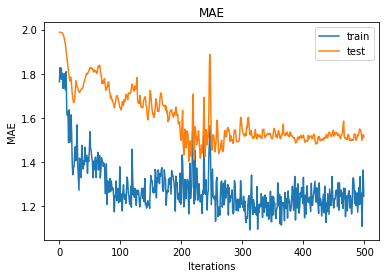

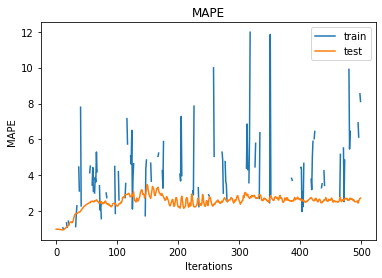

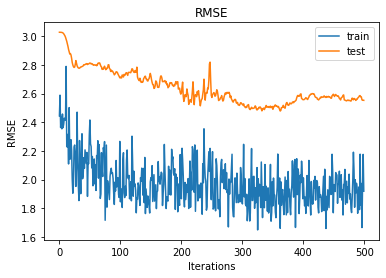

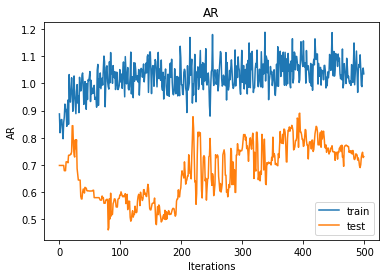

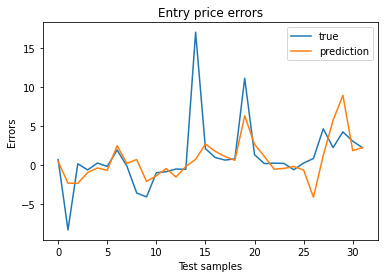

[MSE Baseline] train: 4.58320459262548  test: 8.240952977742106
['Gen_loss', 'Dis_loss', 'Gen_mse_loss', 'MSE', 'MAE', 'MAPE', 'RMSE', 'AR'] =
 [0.82826239 1.29015183 6.5835433  6.35295105 1.50716746 2.7685926
 2.47830343 0.82303101]


In [38]:
i = 3 #data_names = ["GOOG","AAPL","AMZN","FB","TSLA"]

data_name = data_names[i]
data_path="GAN-stock-entry/datasets/"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path).dropna()

dataframe = add_Entry(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

generator = make_generator_model()
discriminator=make_discriminator_model()

learning_rate=1e-4
generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

@tf.function
def train_step(sequences, sequences_end):
  return train_step_def(sequences, sequences_end)

@tf.function
def test_step(sequences, sequences_end):
  return test_step_def(sequences, sequences_end)

checkpoint_dir = './training_checkpoints'+data_name
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

history, history_val = train(data_gen_train, data_gen_test, EPOCHS)

plot_history(history, history_val)
plot_frame(*data_gen_test[0], generator)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))

results[i] = get_best_results(history_val)
print(metrics,"=\n",results[i])

### Tesla Stock

GAN-stock-entry/datasets/TSLA.csv
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 5, 10)             720       
_________________________________________________________________
batch_normalization_10 (Batc (None, 5, 10)             40        
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 5, 10)             0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 5, 10)             0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 10)                840       
_________________________________________________________________
batch_normalization_11 (B

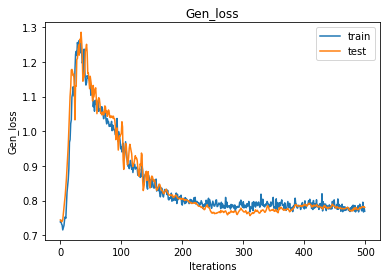

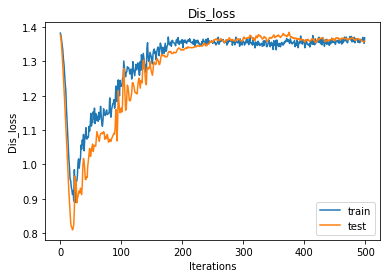

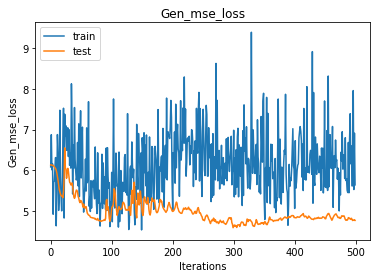

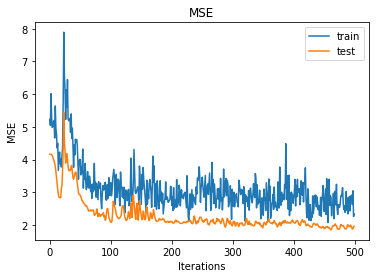

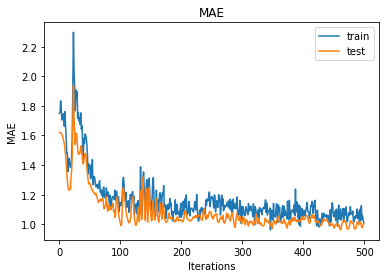

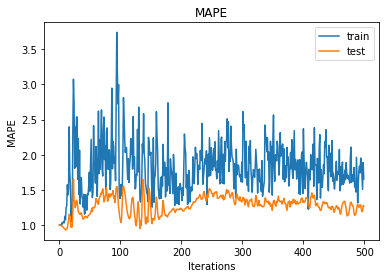

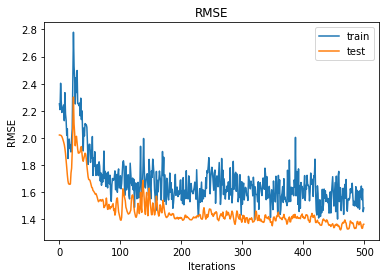

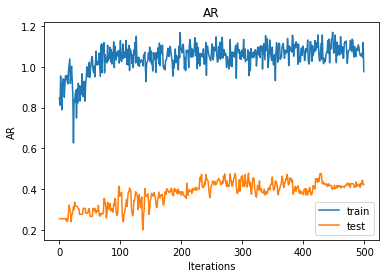

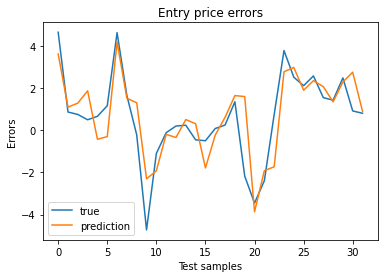

[MSE Baseline] train: 3.7214513865598726  test: 2.5058397803284445
['Gen_loss', 'Dis_loss', 'Gen_mse_loss', 'MSE', 'MAE', 'MAPE', 'RMSE', 'AR'] =
 [0.77616543 1.3678236  4.77399158 1.84857869 0.96184766 1.15671277
 1.32276917 0.41243953]


In [39]:
i = 4 #data_names = ["GOOG","AAPL","AMZN","FB","TSLA"]

data_name = data_names[i]
data_path="GAN-stock-entry/datasets/"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path).dropna()

dataframe = add_Entry(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

generator = make_generator_model()
discriminator=make_discriminator_model()

learning_rate=1e-4
generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

@tf.function
def train_step(sequences, sequences_end):
  return train_step_def(sequences, sequences_end)

@tf.function
def test_step(sequences, sequences_end):
  return test_step_def(sequences, sequences_end)

checkpoint_dir = './training_checkpoints'+data_name
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

history, history_val = train(data_gen_train, data_gen_test, EPOCHS)

plot_history(history, history_val)
plot_frame(*data_gen_test[0], generator)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))

results[i] = get_best_results(history_val)
print(metrics,"=\n",results[i])

## Results

In [40]:
df = pd.DataFrame(data = results, index = data_names, columns = metrics)
df.loc['mean'] = results.mean(axis=0)
df

,Gen_loss,Dis_loss,Gen_mse_loss,MSE,MAE,MAPE,RMSE,AR
GOOG,0.779216,1.341688,4.461814,2.263794,1.084490,1864.378540,1.480158,0.521023
AAPL,0.788493,1.331989,4.912818,3.722417,1.341604,1.649706,1.893106,0.371834
AMZN,0.764364,1.375842,3.859277,2.669446,1.081774,3.480447,1.583731,0.472510
FB,0.828262,1.290152,6.583543,6.352951,1.507167,2.768593,2.478303,0.823031
TSLA,0.776165,1.367824,4.773992,1.848579,0.961848,1.156713,1.322769,0.412440
mean,0.787300,1.341499,4.918289,3.371437,1.195377,374.686800,1.751614,0.520167
